In [3]:
import pandas as pd
from datetime import datetime   # 패키지 - 모듈 (이름 같음)
import pandas as pd   # csv file read
import matplotlib.pyplot as plt   # 시계열 시각화
from sklearn.preprocessing import LabelEncoder # 인코딩
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
plt.rcParams['axes.unicode_minus'] =False
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import os
plt.style.use('ggplot')
import pandas as pd
from datetime import datetime   # 패키지 - 모듈 (이름 같음)
import pandas as pd   # csv file read
import matplotlib.pyplot as plt   # 시계열 시각화
from sklearn.preprocessing import LabelEncoder # 인코딩
import numpy as np
import statsmodels.api as sm
pd.options.display.float_format = '{:.2f}'.format
import datetime
plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import os
plt.style.use('ggplot')


In [4]:
df = pd.read_csv('C:/Users/yjhon/OneDrive/바탕 화면/조달청_공모전/Regression_timeseries/물품용역공사_2017_2021.xls',index_col='공고게시일자')

In [5]:
df.index = df.index.astype(str)

df.index = pd.to_datetime(df.index)

In [6]:
water_df = df[df.수요기관명 == "한국수자원공사"] # 용역
water_df_service = water_df[water_df.대상 == "용역"]

In [7]:
col_name = ["추정가격"]
water_service = pd.DataFrame(data = water_df_service,columns = col_name)

In [8]:
water_service['date'] = water_service.index
water_service.dtypes

water_service['date'] = water_service['date'].astype(str)

water_service['date'] = pd.to_datetime(water_service['date'])

water_groups = water_service.groupby(["date"]).추정가격.sum()
water_group_df = pd.DataFrame(data=water_groups, index = water_groups.index)

water_group_df.tail()

,추정가격
date,
2021-12-27,162250600.00
2021-12-28,306701000.00
2021-12-29,361531000.00
2021-12-30,689758200.00
2021-12-31,3045898000.00


In [9]:
water_sample = water_group_df.resample(rule='w').sum()

In [10]:
water_sample = water_sample[water_sample.추정가격!=0] # 0값 제외한 데이터프레임

In [11]:
water_sample

,추정가격
date,
2018-04-08,1213394500.00
2018-04-15,2100809455.00
2018-04-22,5161653780.00
2018-04-29,1889171056.00
2018-05-06,8386696600.00
...,...
2021-12-05,15323871280.00
2021-12-12,15572623196.00
2021-12-19,23078195505.00


Text(0.5, 1.0, '한국수자원공사 용역 추정가격_week')

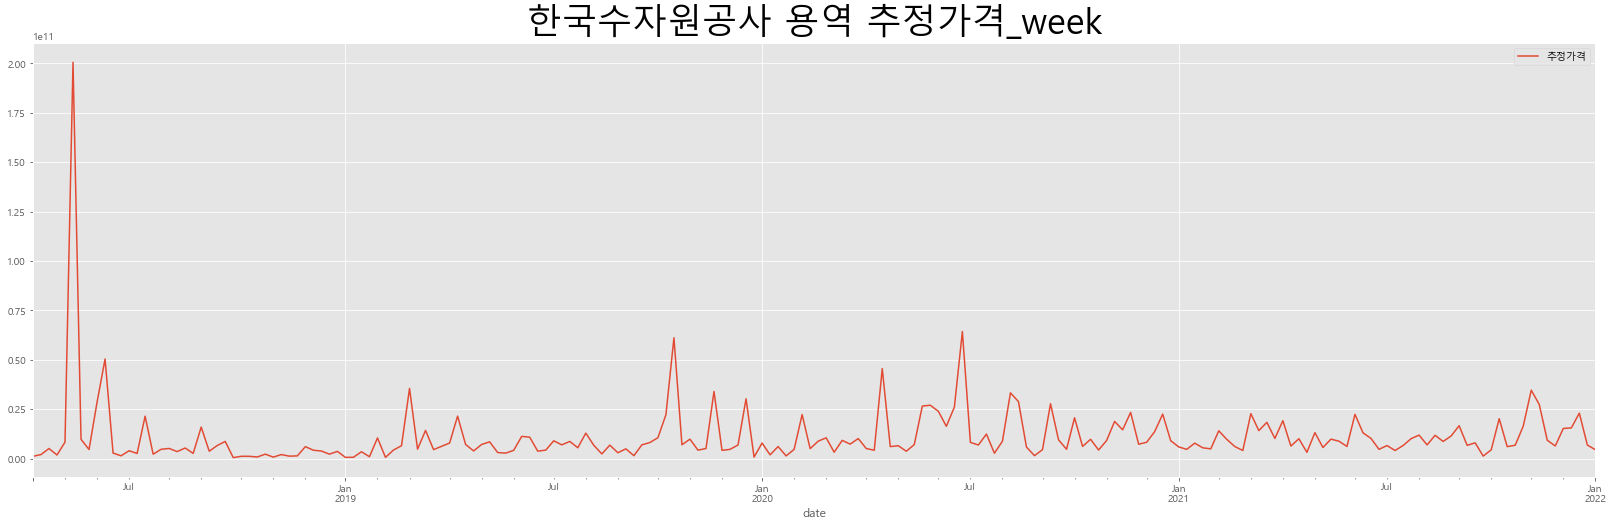

In [12]:
water_sample.plot(figsize=(28,8))
plt.title("한국수자원공사 용역 추정가격_week",fontsize=35)

In [13]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(water_sample[1:])
print('ADF Statistic: %f'%result[0])
print('p-value : %f'%result[1])
print('Critical values:')
for key, value in result[4].items():
    print('\t%s:%.3f'%(key,value))

ADF Statistic: -13.060865
p-value : 0.000000
Critical values:
	1%:-3.465
	5%:-2.877
	10%:-2.575


In [14]:
# 검정통계량(ADF Statistics)가 Critical Value 보다 작으면 Stationary한 데이터
# 혹은 p-value가 설정한 신뢰수준 값 (0.05)보다 작으면 Stationary한 데이터

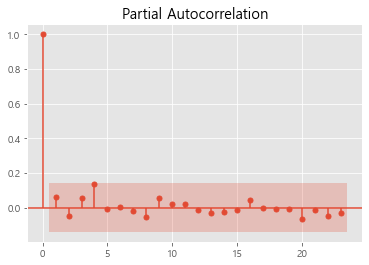

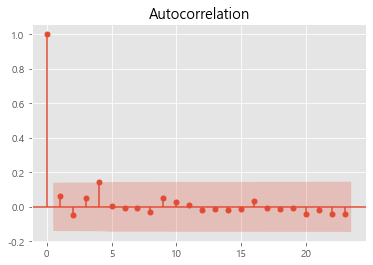

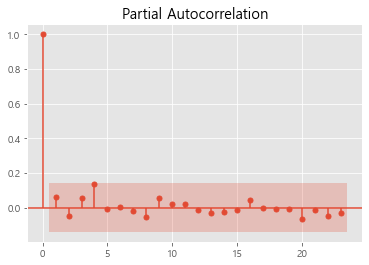

In [15]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(water_sample.추정가격)
plot_pacf(water_sample.추정가격)

In [471]:
water_sample_log = np.log(water_sample)
water_sample_log.shape

(196, 1)

<AxesSubplot:xlabel='date'>

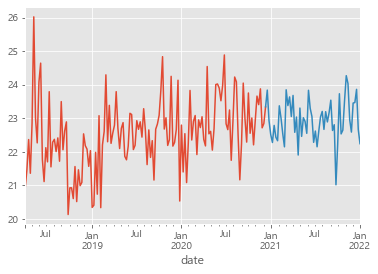

In [472]:
y_train = water_sample_log['추정가격'][:141]
y_test = water_sample_log['추정가격'][140:196]
y_train.plot()
y_test.plot()

In [473]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pmdarima.arima import ndiffs
import pmdarima as pm

kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)
print(f"추정된 차수 d = {n_diffs}")

추정된 차수 d = 1


In [474]:
model = pm.auto_arima(y = y_train        # 데이터
                      , d =1            # 차분 차수, ndiffs 결과!
                      , start_p = 0 
                      , max_p = 5   
                      , start_q = 0 
                      , max_q = 5   
                      , m = 52       
                      , seasonal = True # 계절성 ARIMA가 아니라면 필수!
                      , stepwise = True
                      , trace=True
                      #, trend = True
                      )
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=456.247, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=428.556, Time=0.57 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=398.280, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=454.275, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=397.693, Time=0.09 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=398.449, Time=0.83 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=397.975, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=427.066, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[52]             : AIC=395.892, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[52]             : AIC=396.677, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[52]             : AIC=396.50

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 0, 0, 52),
      suppress_warnings=True, with_intercept=False)

In [546]:
from pmdarima import auto_arima
stepwise_model = auto_arima(y_train, start_p=0, start_q=0,
                           max_p=1, max_q=1, m=52,
                           start_P=1, seasonal=True
                           #d=1
                            , D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=309.406, Time=2.16 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=312.594, Time=0.10 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=305.259, Time=2.22 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=305.649, Time=2.93 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=321.558, Time=0.12 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=309.994, Time=0.26 sec
 ARIMA(1,0,0)(2,1,0)[52] intercept   : AIC=307.259, Time=6.47 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=307.259, Time=2.40 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=305.259, Time=3.71 sec
 ARIMA(1,0,0)(0,1,2)[52] intercept   : AIC=inf, Time=7.71 sec
 ARIMA(1,0,0)(1,1,2)[52] intercept   : AIC=309.259, Time=6.37 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=307.406, Time=2.64 sec
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=307.057, Time=4.05 sec
 ARIMA(1,0,0)(0,1,1)[52]             : AIC=312.813, Time=1.74 sec

Best model:  ARIMA(1,0,0)(0,1,1)[52]

In [723]:
SARIMAMonth = sm.tsa.statespace.SARIMAX(y_train, order=(1,1,0), seasonal_order=(0,1,1,52) ,enforce_stationarity=False,enforce_invertibility=False)

SARIMA_results_month = SARIMAMonth.fit()

SARIMA_results_month.plot_diagnostics(figsize=(16, 8))
plt.show()

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1152x576 with 0 Axes>

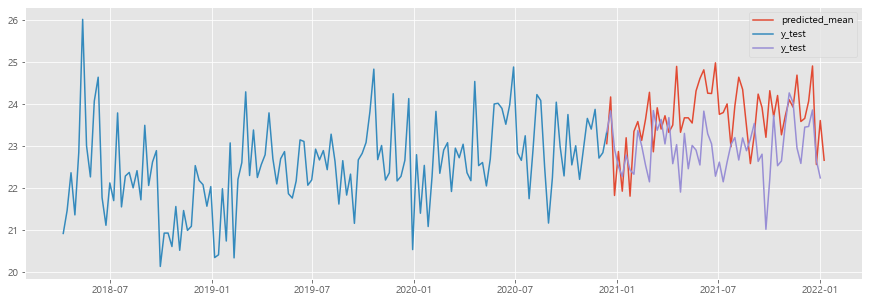

In [728]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_month_train = SARIMA_results_month.predict(start=140,end=196)

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
#salesbymonth_test_final['SeasonalARIMA'] = SARIMA_predict_month_1

# RMSE를 살펴 봄
#RMSE_Month_Seasonal_ARIMA  = np.mean(np.sqrt((salesbymonth_test_final['SeasonalARIMA'] - salesbymonth_test_final['sales']) ** 2)) 
#print(RMSE_Month_Seasonal_ARIMA)

# test 데이터와 예측 결과치를 비교
plt.figure(figsize=(15,5))
plt.plot(SARIMA_predict_month_train,label = 'predicted_mean')
plt.plot(y_train,label='y_test')
plt.plot(y_test,label='y_test')
plt.legend()
plt.show()

<AxesSubplot:>

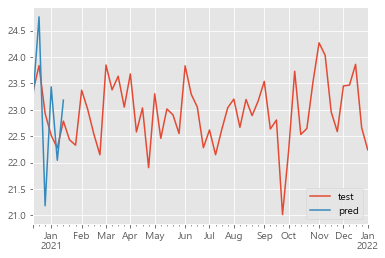

In [722]:
test_pred=pd.DataFrame({"test": y_test, "pred": SARIMA_predict_month_train})
test_pred.plot()
#test_pred #11061990545.46

In [740]:
prediction = SARIMA_results_month.get_forecast(len(y_test))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()['lower 추정가격']
predicted_lb = prediction.conf_int()['upper 추정가격']
predict_index = list(y_test.index)
r2 = r2_score(y_test, predicted_value)

In [741]:
predicted_ub

2020-12-20   21.55
2020-12-27   18.32
2021-01-03   18.65
2021-01-10   17.09
2021-01-17   17.82
2021-01-24   15.93
2021-01-31   17.03
2021-02-07   16.84
2021-02-14   15.99
2021-02-21   16.12
2021-02-28   16.40
2021-03-07   14.64
2021-03-14   15.36
2021-03-21   14.53
2021-03-28   14.54
2021-04-04   13.85
2021-04-11   13.73
2021-04-18   14.86
2021-04-25   13.02
2021-05-02   13.10
2021-05-09   12.84
2021-05-16   12.47
2021-05-23   12.99
2021-05-30   13.05
2021-06-06   13.02
2021-06-13   12.23
2021-06-20   12.00
2021-06-27   12.51
2021-07-04   11.06
2021-07-11   10.89
2021-07-18   10.89
2021-07-25    9.66
2021-08-01   10.43
2021-08-08   10.91
2021-08-15   10.42
2021-08-22    9.35
2021-08-29    8.26
2021-09-05    8.76
2021-09-12    9.54
2021-09-19    9.04
2021-09-26    8.15
2021-10-03    9.08
2021-10-10    8.28
2021-10-17    8.61
2021-10-24    7.49
2021-10-31    7.78
2021-11-07    7.99
2021-11-14    7.64
2021-11-21    8.24
2021-11-28    6.97
2021-12-05    6.88
2021-12-12    7.12
2021-12-19  

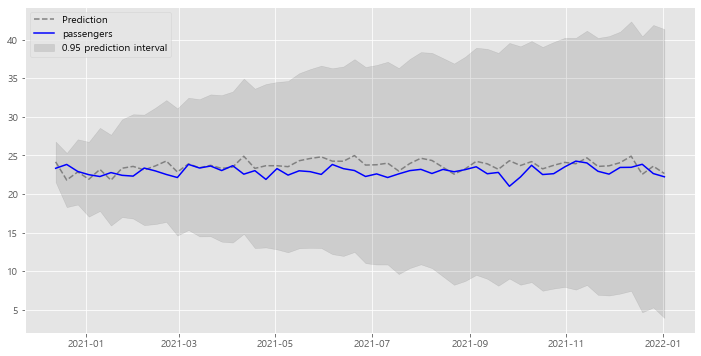

In [742]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(predict_index, predicted_value, linestyle='--', label='Prediction', color='gray')
ax.plot(y_test[predict_index[0]:].index, y_test[predict_index[0]:], label='passengers',color='blue')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='0.95 prediction interval')
plt.legend(loc='upper left')

In [668]:
from sklearn.metrics import r2_score
y_test_temp = y_test[:6]
R2 = r2_score(y_test_temp.values, SARIMA_predict_month_train.values)
print(R2)

-0.14094999043361067


<AxesSubplot:xlabel='date'>

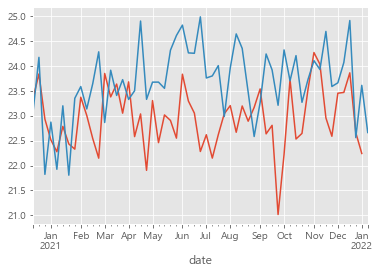

In [730]:
y_test.plot()
SARIMA_predict_month_train.plot()

In [767]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = SARIMA_predict_month_train, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = (predicted_ub + predicted_lb)/2 #[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="한국수자원공사_용역_ARIMA(2,2,0)모형")
fig.show()

In [765]:
(predicted_ub + predicted_lb)/1.8

2020-12-20   26.86
2020-12-27   24.25
2021-01-03   25.41
2021-01-10   24.36
2021-01-17   25.78
2021-01-24   24.23
2021-01-31   25.95
2021-02-07   26.21
2021-02-14   25.71
2021-02-21   26.27
2021-02-28   26.98
2021-03-07   25.40
2021-03-14   26.57
2021-03-21   26.01
2021-03-28   26.36
2021-04-04   25.92
2021-04-11   26.11
2021-04-18   27.67
2021-04-25   25.92
2021-05-02   26.31
2021-05-09   26.31
2021-05-16   26.17
2021-05-23   27.02
2021-05-30   27.35
2021-06-06   27.58
2021-06-13   26.96
2021-06-20   26.95
2021-06-27   27.76
2021-07-04   26.40
2021-07-11   26.44
2021-07-18   26.67
2021-07-25   25.54
2021-08-01   26.62
2021-08-08   27.38
2021-08-15   27.06
2021-08-22   26.08
2021-08-29   25.09
2021-09-05   25.85
2021-09-12   26.93
2021-09-19   26.58
2021-09-26   25.79
2021-10-03   27.02
2021-10-10   26.34
2021-10-17   26.90
2021-10-24   25.86
2021-10-31   26.36
2021-11-07   26.79
2021-11-14   26.59
2021-11-21   27.44
2021-11-28   26.21
2021-12-05   26.29
2021-12-12   26.74
2021-12-19  

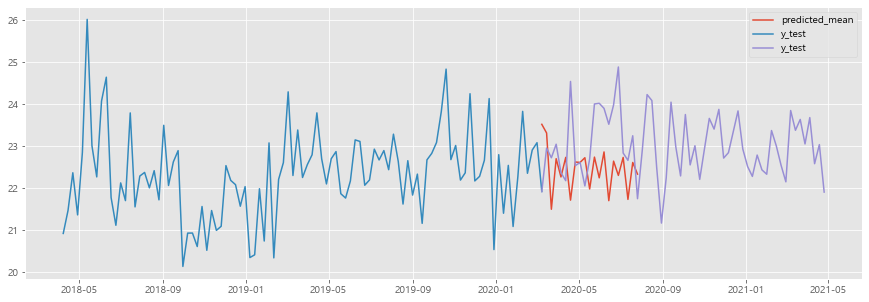

In [405]:
# 2017년 12개월 데이터로 예측
SARIMA_predict_month_1 = SARIMA_results_month.predict(start=100,end=120)

# 결과 비교를 위해 기존에 마련해둔 test데이터에 결과를 붙임
#salesbymonth_test_final['SeasonalARIMA'] = SARIMA_predict_month_1

# RMSE를 살펴 봄
#RMSE_Month_Seasonal_ARIMA  = np.mean(np.sqrt((salesbymonth_test_final['SeasonalARIMA'] - salesbymonth_test_final['sales']) ** 2)) 
#print(RMSE_Month_Seasonal_ARIMA)

# test 데이터와 예측 결과치를 비교
plt.figure(figsize=(15,5))
plt.plot(SARIMA_predict_month_1,label = 'predicted_mean')
plt.plot(y_train,label='y_test')
plt.plot(y_test,label='y_test')
plt.legend()
plt.show()

In [341]:
from sklearn.metrics import r2_score
R2 = r2_score(y_test[:4], SARIMA_predict_month_1.values)
print(R2)

-1.8920979521323158


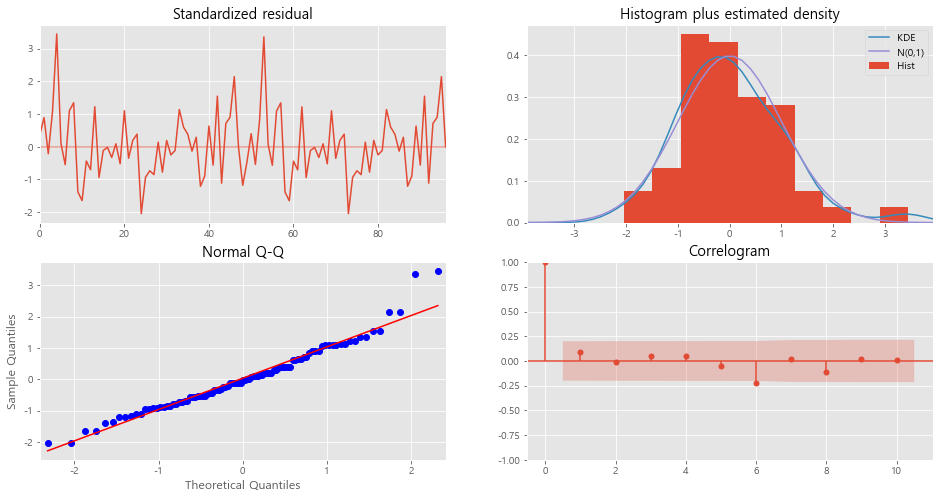

In [301]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

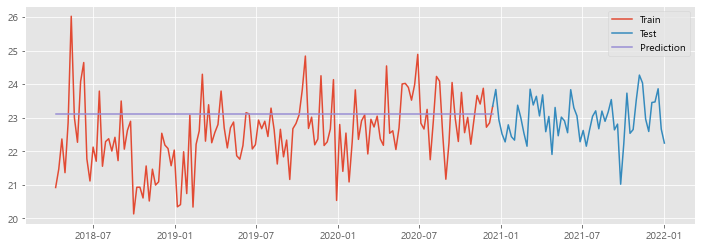

In [754]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(y_train)) 
y_predict = pd.DataFrame(y_predict,index = y_train.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [755]:
def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [756]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_train:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model.update(new_ob)

In [757]:
test_pred=pd.DataFrame({"test": y_train, "pred": y_pred})
#test_pred #11061990545.46

<AxesSubplot:xlabel='date'>

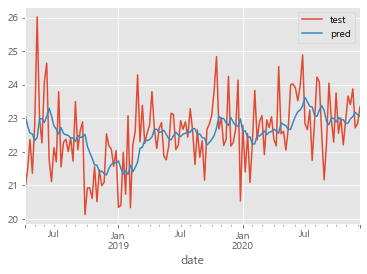

In [758]:
test_pred.plot()

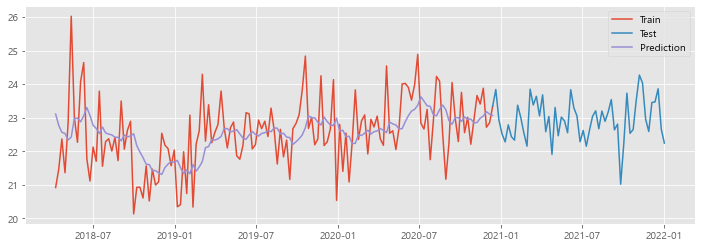

In [759]:
# 테스트 데이터 개수만큼 예측
y_predict = model.predict(n_periods=len(water_sample)) 
y_predict = pd.DataFrame(y_predict,index = water_sample.index,columns=['Prediction'])
y_pred_df = pd.DataFrame(data=y_pred,index=y_train.index)
# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(y_train, label='Train')        # 훈련 데이터
plt.plot(y_test, label='Test')          # 테스트 데이터
plt.plot(y_pred_df, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

In [760]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="한국수자원공사_용역_ARIMA(2,2,0)모형")
fig.show()

In [753]:
pred_lower

[]

In [208]:
from sklearn.metrics import r2_score
R2 = r2_score(y_train.values, y_pred)
print(R2)

0.0009220905240979738


In [159]:
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred) 
mae = mean_absolute_error(y_test, y_pred) 
rmse = mse ** 0.5 
r2 = r2_score(y_test, y_pred)

print("raw")
print("===> mse:",mse)
print("===> mae:",mae)
print("===> rmse:",rmse)
print("===> r2:",r2)

raw
===> mse: 3.6323770472875168e+19
===> mae: 4329591107.18805
===> rmse: 6026920480.052409
===> r2: -0.38220534480099433


In [ ]:
def Mpe(y,pred):
    return np.mean((y-pred)/y)*100
print(Mpe(y_test,y_pred))